In [27]:
# 导入数据集
import torch

print(torch.__version__)

2.0.0+cu117


In [28]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [29]:
# 读入数据
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [30]:
x_train.shape

(50000, 784)

即总共有50000张图片，每张图片像素点个数为28 * 28 * 1 = 784

In [31]:
# x_train[0]  # 第一张图片
x_train[0].reshape(28, 28)  # 转换为二维，图像

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [32]:
y_train[:].shape  # 代表50000张预测结果

(50000,)

(50000, 784)


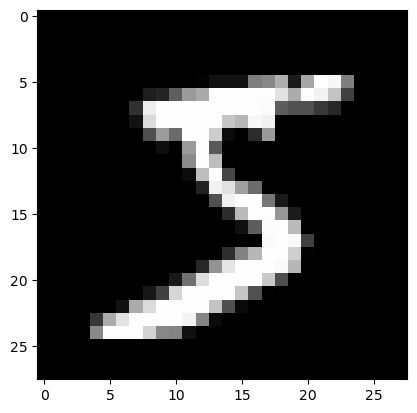

In [33]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

注意数据需转换成tensor才能参与后续建模训练

In [34]:
import torch

# 都映射为Tensor格式
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [35]:
import torch.nn.functional as F

# 交叉熵损失
loss_func = F.cross_entropy


def model(xb):
    return xb.mm(weights) + bias

In [36]:
bs = 64  # batchsize
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]  # 每一批取64张图片
weights = torch.randn([784, 10], dtype=torch.float, requires_grad=True)  # w为784*10 每一个x为784*1  bias为常数 10列
bs = 64
bias = torch.zeros(10, requires_grad=True)
print(torch.zeros(10, requires_grad=True).shape)
print(loss_func(model(xb), yb))  # （预测值，真实值）

torch.Size([10])
tensor(12.8135, grad_fn=<NllLossBackward0>)


<img src="./img/5.png" alt="FAO" width="790">

In [37]:
# FC = WX + b 全连接神经网络
# 输入是784个像素点（一个batch）
# 例如hidden layer 取128个神经元，两层，W1:784 * 128 b1: 128 ,,, 则W2: 128*10 b2: 10
# 输出的是该样本分别属于10个类别的概率
from torch import nn


class Mnist_NN(nn.Module):  # 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
    # 定义网络
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)  # 两层hidden layer ，b已隐含在Linear
        self.out = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)  # 杀死一半神经元

    # 前向传播——自定义
    def forward(self, x):
        x = F.relu(self.hidden1(x))  # 64 * 784 ————> 64 * 128
        x = F.relu(self.hidden2(x))  # 64 * 128 ————> 64 * 256
        x = self.out(x)  # 64 * 256  ————> 64 * 10 即最后得到输出结果
        return x

# 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
# Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [38]:
# 类做实例化，定义好网络模型
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


使用TensorDataset和DataLoader来简化

In [39]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# DateLoader即将数据Batch打包送往GPU
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)  # shuffle将训练模型的数据集进行打乱的操作，获得随机性

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [40]:
def get_data(train_ds, valid_ds, bs):  # batchsize
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [41]:
import numpy as np


# 有了模型和数据，接下来就是训练
def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    # steps迭代多少轮, model可以是继承nn.module的模型, loss_func损失函数, opt优化器, train_dl训练数据dataloader, valid_dl验证数据dataloader
    for step in range(steps):  # epoch，与数据的batch有关
        model.train()  # 训练steps轮 -- 更新权重参数w，b
        for xb, yb in train_dl:  # 遍历数据打包
            loss_batch(model, loss_func, xb, yb, opt)

        # 与
        model.eval()  # 验证steps轮
        with torch.no_grad():  # 没有梯度时
            losses, nums = zip(  # 一个loss对应一个number(就是每一批数据对应一个损失值)
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )  # 这里是解开，可以单独解开拿到loss 或者 是样本个数
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # 计算验证集的损失，将loss与nums相乘，计算总的损失，再比上样本个数np.sum(nums)，即可得到平均损失
        print('当前step:' + str(step), '验证集损失：' + str(val_loss))

In [42]:
# zip用法 -- 进行配对
a = [1, 2, 3]
b = [5, 6, 4]
zipped = zip(a, b)
print(list(zipped))
a1, b1 = zip(*zip(a, b))  # 解包
print(a1)
print(b1)

[(1, 5), (2, 6), (3, 4)]
(1, 2, 3)
(5, 6, 4)


In [43]:
# 优化器
from torch import optim


def get_model():
    model = Mnist_NN()
    return model, optim.Adam(model.parameters(), lr=0.001)


# 1.计算损失 2.更新参数
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()  # 反向传播
        opt.step()  # 更新所有参数
        opt.zero_grad()  # 更新一次后置零，下一次重新更新, 即表示这一批的batch已经不需要进行到下一次的参数优化

    return loss.item(), len(xb)


'''
在每一次batch'训练完之后，计算得到loss损失函数和相应梯度，都会对模型参数进行调整，那么该batch数据在这一轮训练里面的作用已经完成了。我们不希望这些优化过模型参数的batch的loss梯度累积起来，继续对模型参数优化产生影响。
'''

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)  # 1.获得数据
model, opt = get_model()  # 2.得到模型和优化器
fit(25, model, loss_func, opt, train_dl, valid_dl)  # 训练迭代 25个epoch

当前step:0 验证集损失：0.13493552518785
当前step:1 验证集损失：0.10979250249937177
当前step:2 验证集损失：0.09880197596848012
当前step:3 验证集损失：0.09297838763296604
当前step:4 验证集损失：0.09059687339942903
当前step:5 验证集损失：0.09252806170228868
当前step:6 验证集损失：0.0942947185988538
当前step:7 验证集损失：0.09728429927751422
当前step:8 验证集损失：0.09909784176871181
当前step:9 验证集损失：0.10378671377263964
当前step:10 验证集损失：0.10469342709593475
当前step:11 验证集损失：0.11258808255868498
当前step:12 验证集损失：0.1240109562828904
当前step:13 验证集损失：0.11996841338849626
当前step:14 验证集损失：0.14289410865949467
当前step:15 验证集损失：0.1115389127304079
当前step:16 验证集损失：0.12898701641003135
当前step:17 验证集损失：0.15260663023177184
当前step:18 验证集损失：0.12175990320676355
当前step:19 验证集损失：0.14202047338490376
当前step:20 验证集损失：0.13796342310593462
当前step:21 验证集损失：0.1337134968128954
当前step:22 验证集损失：0.14259795458848248
当前step:23 验证集损失：0.15720129236354552
当前step:24 验证集损失：0.17348731791549946


# 练习

In [44]:
correct = 0  # 正确样本数
total = 0  # 总样本数
print(model(xb))
print(model(xb).shape)
torch.max(model(xb), 1)  # 返回每一行的最大值，和最大值所在位置的索引
# 模型输出结果沿着某个维度的最大值，这里是维度为1的方向
for xb, yb in valid_dl:
    output = model(xb)
    _, predicted = torch.max(model(xb), 1)
    total += yb.size(0)
    print(yb.size(0))
    print((predicted == yb).sum())


tensor([[-47.3098, -18.2802, -30.2562,   6.3072, -52.6972,  36.3068, -26.7845,
         -41.3497, -21.4862, -17.0548],
        [ 29.5517, -19.7182,  -7.6735, -19.5100, -33.8363, -19.8235,  -9.8674,
         -23.0205, -25.1620, -11.6698],
        [-18.9329, -10.0561,  -7.4064, -11.8661,  14.6177, -17.4477, -14.1790,
          -3.3254,  -2.3840,  -4.6459],
        [-15.2178,  13.8495,  -8.9267, -24.8085,  -3.2309, -22.1544, -13.4722,
          -2.6204,  -8.0360, -20.1364],
        [-29.8075, -18.5832, -18.1894, -14.3028,   1.1365, -19.9879, -26.5294,
          -9.2991,  -5.9546,  15.3512],
        [-21.2264,  -7.4369,  17.0063, -12.9053,  -6.2728, -21.7724, -16.3860,
           1.4229, -13.0696, -24.0961],
        [-40.3368,  15.3898, -16.1543, -16.4161, -18.4550, -12.0896, -14.4719,
          -4.7131,  -0.1237, -14.7855],
        [-62.6836, -31.7775, -24.2663,  38.2194, -37.4304,  -8.0847, -67.8983,
         -29.4291,  -7.6150,   1.1743],
        [-24.9038,  10.1504, -15.5859,  -8.5789,

In [45]:
# 计算准确率(对验证集或者测试集计算) -- 即这50000个样本中分类正确的样本个数
correct = 0  # 正确样本数
total = 0  # 总样本数
for xb, yb in valid_dl:
    output = model(xb)
    _, predicted = torch.max(model(xb), 1)
    total += yb.size(0)
    correct += (predicted == yb).sum().item()

print("Accuracy of the network on the 10000 test images: %d%%" % (100 * correct / total))

Accuracy of the network on the 10000 test images: 97%


## SGD 正确率89%
## Adam 正确率97%